# Dependencies

In [1]:
import qutip as qp
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import qiskit
from qiskit.circuit.library import HamiltonianGate, UnitaryGate, RYGate, RZGate
from qiskit import Aer, transpile, QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, thermal_relaxation_error
from qiskit.providers.fake_provider import *

# Hamiltonian

In [2]:
class Hamiltonian:
    def __init__(self, N, kappa, theta, rho, Phi):
        """
        N: Number of neutrinos
        kappa: Relative strength of one body energy divided by the number of neutrinos
        theta: Mixing angle
        rho: Electron relative density
        Phi: Propagation angle matrix, Phi[i,j] for i<j is the propagation angle between neutrinos i and j.
        """
        assert Phi.shape == (N,N)
        self.N = N
        self.kappa = kappa
        self.theta = theta
        self.rho = rho
        self.Phi = Phi
        self.b1 = self.kappa * np.sin(2*self.theta)
        self.b2 = 0
        self.b3 = self.rho/2 - self.kappa * np.cos(2*self.theta)

    def pauliX(i,N):
        return qp.tensor([qp.sigmax() if j == i else qp.identity(2) for j in range(N)])

    def pauliY(i,N):
        return qp.tensor([qp.sigmay() if j == i else qp.identity(2) for j in range(N)])
    
    def pauliZ(i,N):
        return qp.tensor([qp.sigmaz() if j == i else qp.identity(2) for j in range(N)])
        
    def toQObj(self):
        """Return Hamiltonian as qutip QObj"""        
        H = qp.tensor([0 * qp.identity(2) for i in range(self.N)]) # initial H to zero matrix

        for i in range(self.N):
            X = Hamiltonian.pauliX(i, self.N)
            Y = Hamiltonian.pauliY(i, self.N)
            Z = Hamiltonian.pauliZ(i, self.N)
            H += self.b1*X + self.b2*Y + self.b3*Z
        
        for i in range(self.N):
            for j in range(i+1, self.N):
                phi = self.Phi[i,j]
                Xi = Hamiltonian.pauliX(i, self.N)
                Yi = Hamiltonian.pauliY(i, self.N)
                Zi = Hamiltonian.pauliZ(i, self.N)
                Xj = Hamiltonian.pauliX(j, self.N)
                Yj = Hamiltonian.pauliY(j, self.N)
                Zj = Hamiltonian.pauliZ(j, self.N)
                H += (1-np.cos(phi))/self.N * (Xi * Xj + Yi * Yj + Zi * Zj)

        return H

    def oneBodyGate(self, t):
        a = self.b1
        b = self.b3
        c = np.sqrt(a**2+b**2)
        Ry_angle = 2*np.arctan2(c-b,a)
        Rz_angle = 2*t*c
        return RYGate(-Ry_angle), RZGate(Rz_angle), RYGate(Ry_angle)

    def pairGate(self, t, i, j):
        """Return Hamiltonian for neutrino i and j as QObj for Hamiltonian Gate"""
        assert i < j, "expect i < j"
        
        X0 = Hamiltonian.pauliX(0, 2)
        Y0 = Hamiltonian.pauliY(0, 2)
        Z0 = Hamiltonian.pauliZ(0, 2)
        X1 = Hamiltonian.pauliX(1, 2)
        Y1 = Hamiltonian.pauliY(1, 2)
        Z1 = Hamiltonian.pauliZ(1, 2)
        H = (self.b1 * (X0 + X1) + self.b2 * (Y0 + Y1) + self.b3 * (Z0 + Z1))/(self.N-1) + (1 - np.cos(self.Phi[i,j]))/self.N * (X0*X1+Y0*Y1+Z0*Z1)
        return HamiltonianGate(H.data.toarray(), t, label=f'PairHamiltonian {i},{j}')

    def interactionGate(self, t, i, j):
        """Return the interaction term between neutrinos i and j as qiskit HamiltonianGate"""
        X0 = Hamiltonian.pauliX(0, 2)
        Y0 = Hamiltonian.pauliY(0, 2)
        Z0 = Hamiltonian.pauliZ(0, 2)
        X1 = Hamiltonian.pauliX(1, 2)
        Y1 = Hamiltonian.pauliY(1, 2)
        Z1 = Hamiltonian.pauliZ(1, 2)
    
        H = (1 - np.cos(self.Phi[i,j]))/self.N * (X0 * X1 + Y0 * Y1 + Z0 * Z1)
        return HamiltonianGate(H.data.toarray(), t, label=f'PairHamiltonian {i},{j}')

    def oneBodyQObj(self):
        """Return one-body Hamiltonian as qutip QObj"""        
        H = qp.tensor([0 * qp.identity(2) for i in range(self.N)]) # initialize H to zero matrix

        for i in range(self.N):
            X = Hamiltonian.pauliX(i, self.N)
            Y = Hamiltonian.pauliY(i, self.N)
            Z = Hamiltonian.pauliZ(i, self.N)
            H += self.b1*X + self.b2*Y + self.b3*Z
            
        return H

    def pairQObj(self, i, j):
        """Return Hamiltonian for neutrino i and j as QObj"""
        assert i < j, "expect i < j"
        
        X0 = Hamiltonian.pauliX(i, self.N)
        Y0 = Hamiltonian.pauliY(i, self.N)
        Z0 = Hamiltonian.pauliZ(i, self.N)
        X1 = Hamiltonian.pauliX(j, self.N)
        Y1 = Hamiltonian.pauliY(j, self.N)
        Z1 = Hamiltonian.pauliZ(j, self.N)
        H = (self.b1 * (X0 + X1) + self.b2 * (Y0 + Y1) + self.b3 * (Z0 + Z1))/(self.N-1) + (1 - np.cos(self.Phi[i,j]))/self.N * (X0*X1+Y0*Y1+Z0*Z1)
        return H

    def interactionQObj(self, i, j):
        """Return the interaction term between neutrinos i and j as qutip QObj"""
        X0 = Hamiltonian.pauliX(i, self.N)
        Y0 = Hamiltonian.pauliY(i, self.N)
        Z0 = Hamiltonian.pauliZ(i, self.N)
        X1 = Hamiltonian.pauliX(j, self.N)
        Y1 = Hamiltonian.pauliY(j, self.N)
        Z1 = Hamiltonian.pauliZ(j, self.N)
    
        H = (1 - np.cos(self.Phi[i,j]))/self.N * (X0 * X1 + Y0 * Y1 + Z0 * Z1)
        return H

# Initial Conditions

In [90]:
N = 4
kappa = 1/N
theta = 0.195
rho = 0.2
Phi = np.arccos(0.9)/(N-1) * np.array([[abs(i-j) for i in range(N)] for j in range(N)])
Ham = Hamiltonian(N, kappa, theta, rho, Phi)

initial_flavors = [0,0,1,1]

t_start = 0
t_end = 20
steps = 100
shots = 5000

times = np.linspace(t_start, t_end, num=steps)

# Classical Simulations

## Exact

In [4]:
def exact_evolution(t, Ham):
    H = Ham.toQObj()
    U = qp.Qobj(sp.linalg.expm(-1j*t*H), dims = H.dims)
    return U

## Single Trotter

In [5]:
def single_trotter_evolution(t, Ham):
    U = None
    for i in range(N):
        for j in range(i+1,N):
            H = Ham.pairQObj(i,j)
            if U is None:
                U = qp.Qobj(sp.linalg.expm(-1j*t*H), dims = H.dims)
            else:
                U = qp.Qobj(sp.linalg.expm(-1j*t*H), dims = H.dims) * U

    return U

## Double Trotter

In [6]:
def double_trotter_evolution(t, Ham):
    H1 = Ham.oneBodyQObj()
    U = qp.Qobj(sp.linalg.expm(-1j*t*H1), dims = H1.dims)
    
    for i in range(N):
        for j in range(i+1,N):
            H2 = Ham.interactionQObj(i,j)
            U = qp.Qobj(sp.linalg.expm(-1j*t*H2), dims = H2.dims) * U

    return U

## Single Fractal

In [7]:
def single_fractal_evolution(t, Ham):
    U = None
    for i in range(N):
        for j in range(i+1,N):
            H = Ham.pairQObj(i,j)
            if U is None:
                U = qp.Qobj(sp.linalg.expm(-0.5j*t*H), dims = H.dims)
    
            elif not (i == N-2 and j == N-1):
             
                U = U * qp.Qobj(sp.linalg.expm(-0.5j*t*H), dims = H.dims)
            
    H = Ham.pairQObj(N-2, N-1)
    U = U * qp.Qobj(sp.linalg.expm(-1j*t*H), dims = H.dims)

    for i in reversed(range(N)):
        for j in reversed(range(i+1,N)):
            H = Ham.pairQObj(i,j)
            if U is None:
                U = qp.Qobj(sp.linalg.expm(-0.5j*t*H), dims = H.dims)
            elif not (i == N-2 and j == N-1):
                U = U * qp.Qobj(sp.linalg.expm(-0.5j*t*H), dims = H.dims)
    
    return U

## Double Fractal

In [8]:
def double_fractal_evolution(t, Ham):
    H1 = Ham.oneBodyQObj()
    U = qp.Qobj(sp.linalg.expm(-1j*t/2*H1), dims = H1.dims)
    
    for i in range(N):
        for j in range(i+1,N):
            H2 = Ham.interactionQObj(i,j)
            U = qp.Qobj(sp.linalg.expm(-1j*t/2*H2), dims = H2.dims) * U
            
    for i in reversed(range(N)):
        for j in reversed(range(i+1,N)):
            H2 = Ham.interactionQObj(i,j)
            U = qp.Qobj(sp.linalg.expm(-1j*t/2*H2), dims = H2.dims) * U

    U = qp.Qobj(sp.linalg.expm(-1j*t/2*H1), dims = H1.dims) * U
    return U

## Results

In [9]:
def classical_results(ts):
    def inversion_probability(initial_flavors, U):
        initial_state = qp.tensor([qp.basis(2,i) for i in initial_flavors])
        final_state = U * initial_state
        dm = qp.ket2dm(final_state)
        probabilities = [dm.ptrace(i).diag()[1] if initial_flavors[i] == 0 else dm.ptrace(i).diag()[0] for i in range(len(initial_flavors))]
        return np.array(probabilities)
    
    exact_probabilities = np.zeros((N,steps))
    for idx, t in enumerate(ts):
        exact_probabilities[:,idx] = inversion_probability(initial_flavors, exact_evolution(t, Ham))

    single_trotter_probabilities = np.zeros((N,steps))
    for idx, t in enumerate(ts):
        single_trotter_probabilities[:,idx] = inversion_probability(initial_flavors, single_trotter_evolution(t, Ham))

    double_trotter_probabilities = np.zeros((N,steps))
    for idx, t in enumerate(ts):
        double_trotter_probabilities[:,idx] = inversion_probability(initial_flavors, double_trotter_evolution(t, Ham))

    single_fractal_probabilities = np.zeros((N,steps))
    for idx, t in enumerate(ts):
        single_fractal_probabilities[:,idx] = inversion_probability(initial_flavors, single_fractal_evolution(t, Ham))

    double_fractal_probabilities = np.zeros((N,steps))
    for idx, t in enumerate(ts):
        double_fractal_probabilities[:,idx] = inversion_probability(initial_flavors, double_fractal_evolution(t, Ham))

    return exact_probabilities, single_trotter_probabilities, double_trotter_probabilities, single_fractal_probabilities, double_fractal_probabilities
       

In [10]:
exact_probabilities, classical_single_trotter_probabilities, classical_double_trotter_probabilities, classical_single_fractal_probabilities, classical_double_fractal_probabilities = classical_results(times)

C:\Users\wue09\AppData\Local\Temp\ipykernel_15424\3159440284.py:6: RuntimeWarning: divide by zero encountered in log
  axs[0,i].plot(times, np.log(np.abs(exact_probabilities[i] - classical_single_trotter_probabilities[i])), label=f'Single Trotter', color='r')
C:\Users\wue09\AppData\Local\Temp\ipykernel_15424\3159440284.py:7: RuntimeWarning: divide by zero encountered in log
  axs[0,i].plot(times, np.log(np.abs(exact_probabilities[i] - classical_double_trotter_probabilities[i])), label=f'Double Trotter', color='g')
C:\Users\wue09\AppData\Local\Temp\ipykernel_15424\3159440284.py:8: RuntimeWarning: divide by zero encountered in log
  axs[0,i].plot(times, np.log(np.abs(exact_probabilities[i] - classical_single_fractal_probabilities[i])), label=f'Single Fractal', color='b')
C:\Users\wue09\AppData\Local\Temp\ipykernel_15424\3159440284.py:9: RuntimeWarning: divide by zero encountered in log
  axs[0,i].plot(times, np.log(np.abs(exact_probabilities[i] - classical_double_fractal_probabilities[i]

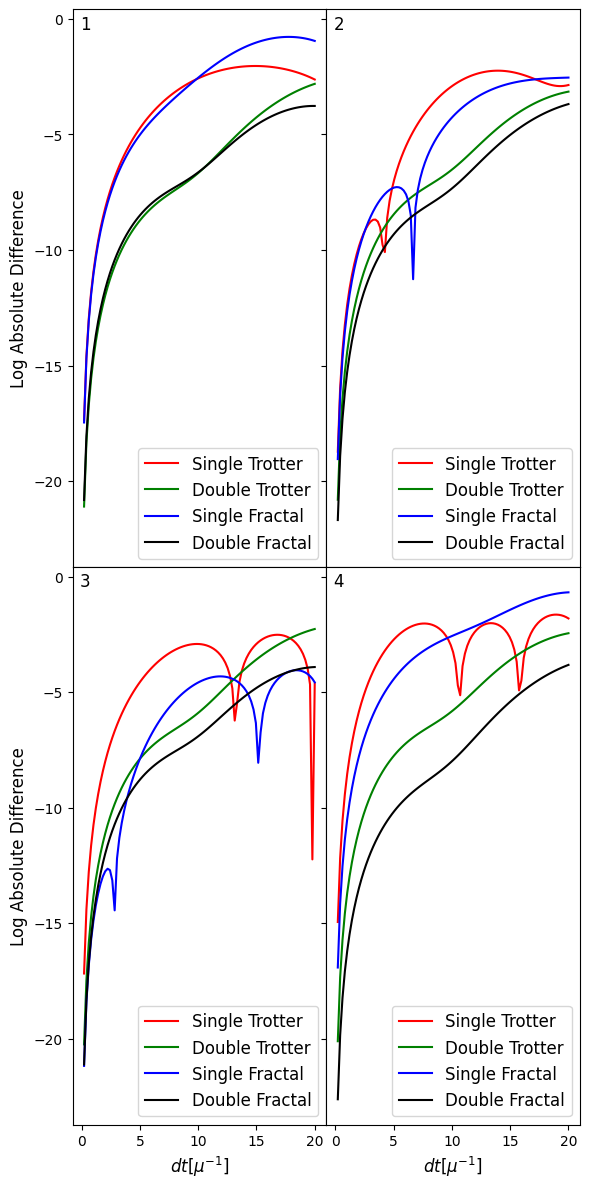

In [55]:
# Plot the probability curve for each qubit on the same graph
plot_qubits = [0,1,2,3]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6, 12), sharey=True)
for i in range(0,2):
    axs[0,i].plot(times, np.log(np.abs(exact_probabilities[i] - classical_single_trotter_probabilities[i])), label=f'Single Trotter', color='r')
    axs[0,i].plot(times, np.log(np.abs(exact_probabilities[i] - classical_double_trotter_probabilities[i])), label=f'Double Trotter', color='g')
    axs[0,i].plot(times, np.log(np.abs(exact_probabilities[i] - classical_single_fractal_probabilities[i])), label=f'Single Fractal', color='b')
    axs[0,i].plot(times, np.log(np.abs(exact_probabilities[i] - classical_double_fractal_probabilities[i])), label=f'Double Fractal', color='black')
    axs[0,i].set_title(f"{i+1}", x=0.05, y=0.95)
    axs[0,i].set_xlabel('$dt [\mu^{-1}]$', fontsize='large')

    axs[0,i].legend(loc='lower right', fontsize='large')
for idx, i in enumerate(range(2,4)):
    axs[1,idx].plot(times, np.log(np.abs(exact_probabilities[i] - classical_single_trotter_probabilities[i])), label=f'Single Trotter', color='r')
    axs[1,idx].plot(times, np.log(np.abs(exact_probabilities[i] - classical_double_trotter_probabilities[i])), label=f'Double Trotter', color='g')
    axs[1,idx].plot(times, np.log(np.abs(exact_probabilities[i] - classical_single_fractal_probabilities[i])), label=f'Single Fractal', color='b')
    axs[1,idx].plot(times, np.log(np.abs(exact_probabilities[i] - classical_double_fractal_probabilities[i])), label=f'Double Fractal', color='black')
    axs[1,idx].set_title(f"{i+1}", x=0.05, y=0.95)
    axs[1,idx].set_xlabel('$dt [\mu^{-1}]$', fontsize='large')
    
    axs[1,idx].legend(loc='lower right', fontsize='large')

axs[0,0].set_ylabel('Log Absolute Difference', fontsize='large')
axs[1,0].set_ylabel('Log Absolute Difference', fontsize='large')
plt.tight_layout()
plt.subplots_adjust(wspace=0)
plt.subplots_adjust(hspace=0)
#fig.text(-0.01, 0.5, 'Log Absolute Difference', va='center', rotation='vertical', fontsize='large')
plt.show()

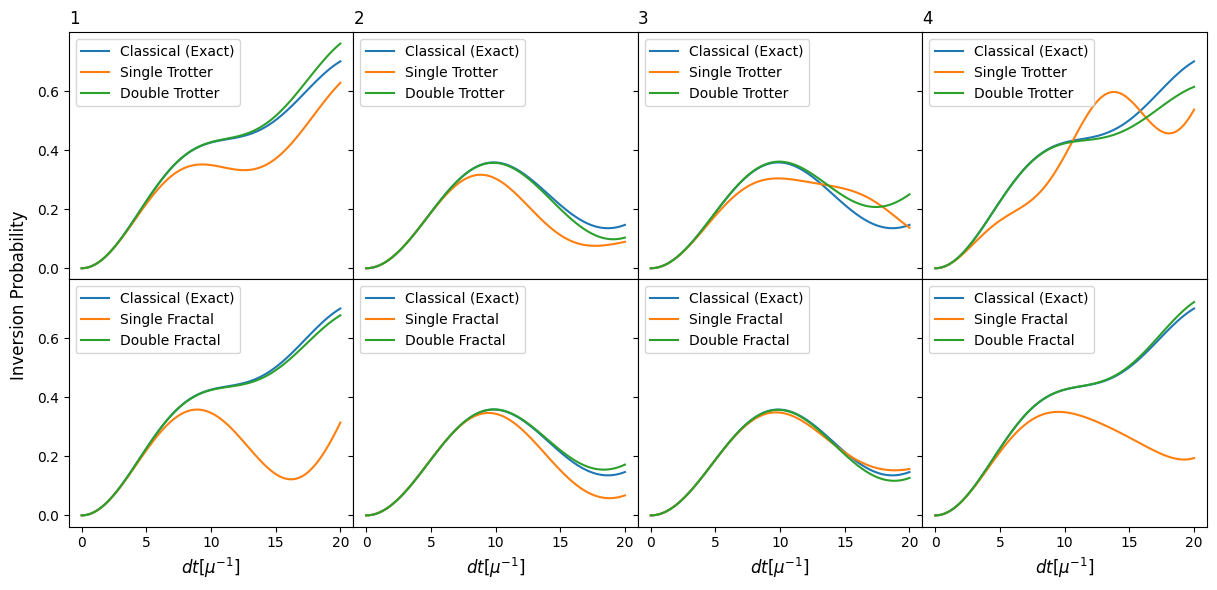

In [63]:
fig, axs = plt.subplots(2,4,figsize=(12, 6), sharex=True, sharey=True)

for i in range(N):
    axs[0,i].plot(times, exact_probabilities[i], label=f'Classical (Exact)')
    axs[0,i].plot(times, classical_single_trotter_probabilities[i], label=f'Single Trotter')
    axs[0,i].plot(times, classical_double_trotter_probabilities[i], label=f'Double Trotter')
    axs[0,i].set_title(f"{i+1}", loc='left')
    axs[0,i].legend(loc='upper left')
    axs[1,i].plot(times, exact_probabilities[i], label=f'Classical (Exact)')
    axs[1,i].plot(times, classical_single_fractal_probabilities[i], label=f'Single Fractal')
    axs[1,i].plot(times, classical_double_fractal_probabilities[i], label=f'Double Fractal')
    axs[1,i].set_xlabel('$dt [\mu^{-1}]$', fontsize='large')
    axs[1,i].legend(loc='upper left')
plt.tight_layout()
plt.subplots_adjust(wspace=0)
plt.subplots_adjust(hspace=0)
fig.text(-0.01, 0.5, 'Inversion Probability', va='center', rotation='vertical', fontsize='large')
plt.show()

# Quantum Simulations

In [14]:
def single_trotter_circuit(t, Ham):
    circuit = QuantumCircuit(Ham.N)
    circuit.initialize("".join(map(str, reversed(initial_flavors))))
    for i in range(N):
        for j in range(i+1,N):
            circuit.append(Ham.pairGate(t,i,j), [i,j])
    circuit.measure_all()
    return circuit

In [15]:
def double_trotter_circuit(t, Ham):
    circuit = QuantumCircuit(Ham.N)
    circuit.initialize("".join(map(str, reversed(initial_flavors))))
    mRy, Rz, Ry = Ham.oneBodyGate(t)
    for i in range(N):
        circuit.append(mRy, [i])
        circuit.append(Rz, [i])
        circuit.append(Ry, [i])
        
    for i in range(N):
        for j in range(i+1,N):
            circuit.append(Ham.interactionGate(t,i,j), [i,j])
            
    circuit.measure_all()
    return circuit

In [16]:
def single_fractal_circuit(t, Ham):
    circuit = QuantumCircuit(Ham.N)
    circuit.initialize("".join(map(str, reversed(initial_flavors))))
    
    for i in range(Ham.N):
        for j in range(i+1,Ham.N):
            if not (i == Ham.N-2 and j == Ham.N-1):
                circuit.append(Ham.pairGate(t/2,i,j), [i,j])
                  
    circuit.append(Ham.pairGate(t, Ham.N-2,Ham.N-1), [Ham.N-2,Ham.N-1])  
            
    for i in reversed(range(Ham.N)):
        for j in reversed(range(i+1,Ham.N)):
            if not (i == Ham.N-2 and j == Ham.N-1):
                circuit.append(Ham.pairGate(t/2,i,j), [i,j])
        
    circuit.measure_all()
    return circuit

In [17]:
def double_fractal_circuit(t, Ham):
    circuit = QuantumCircuit(Ham.N)
    circuit.initialize("".join(map(str, reversed(initial_flavors))))
    mRy, Rz, Ry = Ham.oneBodyGate(t/2)
    
    for i in range(Ham.N):
        circuit.append(mRy, [i])
        circuit.append(Rz, [i])
        circuit.append(Ry, [i])
        
    for i in range(Ham.N):
        for j in range(i+1,Ham.N):
            if not (i == Ham.N-2 and j == Ham.N-1):
                circuit.append(Ham.interactionGate(t/2,i,j), [i,j])
                  
    circuit.append(Ham.interactionGate(t,Ham.N-2,Ham.N-1), [Ham.N-2,Ham.N-1])  
            
    for i in reversed(range(Ham.N)):
        for j in reversed(range(i+1,Ham.N)):
            if not (i == Ham.N-2 and j == Ham.N-1):
                circuit.append(Ham.interactionGate(t/2,i,j), [i,j])
 
    for i in range(Ham.N):
        circuit.append(mRy, [i])
        circuit.append(Rz, [i])
        circuit.append(Ry, [i])
            
    circuit.measure_all()
    return circuit

In [18]:
def inversion_probability(circuit, backend):
    circ = transpile(circuit, backend)        
    result = qiskit.execute(circ, backend, shots=shots).result()
    counts = result.get_counts()
    
    bit_frequencies = [0 for i in range(N)] # A counter for how many times each qubit flips
    outcomes = []
    
    for bitstring, frequency in counts.items():
        bit_list = list(map(int, bitstring))
        bit_list = np.array(list(reversed(bit_list))) # Reverse because little-endian?
        for i in range(frequency):
            inversions = (bit_list + initial_flavors) % 2 # 1 if inverted, 0 if not
            outcomes.append(inversions)
    outcomes = np.array(outcomes)
    assert outcomes.shape == (shots, N)
    
    probability = outcomes.mean(axis=0)
    assert len(probability) == N
    return probability, circ.depth()

In [96]:
def quantum_results(ts, backend):
    single_trotter_probabilities = np.zeros((N,steps))
    double_trotter_probabilities = np.zeros((N,steps))
    single_fractal_probabilities = np.zeros((N,steps))
    double_fractal_probabilities = np.zeros((N,steps))
    single_trotter_depth = []
    double_trotter_depth = []
    single_fractal_depth = []
    double_fractal_depth = []
    for t_idx, t in enumerate(ts):
        #print("Time", t)
        single_trotter_probabilities[:, t_idx], depth = inversion_probability(single_trotter_circuit(t, Ham), backend)
        #print("ST",depth)
        single_trotter_depth.append(depth)

        double_trotter_probabilities[:, t_idx], depth = inversion_probability(double_trotter_circuit(t, Ham), backend)
        #print("DT",depth)
        double_trotter_depth.append(depth)

        single_fractal_probabilities[:, t_idx], depth = inversion_probability(single_fractal_circuit(t, Ham), backend)
        single_fractal_depth.append(depth)
        #print("SF",depth)
        
        double_fractal_probabilities[:, t_idx], depth = inversion_probability(double_fractal_circuit(t, Ham), backend)
        double_fractal_depth.append(depth)
        #print("DF",depth)
    single_trotter_depth = np.mean(single_trotter_depth)
    double_trotter_depth = np.mean(double_trotter_depth)
    single_fractal_depth = np.mean(single_fractal_depth)
    double_fractal_depth = np.mean(double_fractal_depth)
    return single_trotter_probabilities, double_trotter_probabilities, single_fractal_probabilities, double_fractal_probabilities, single_trotter_depth, double_trotter_depth, single_fractal_depth, double_fractal_depth

## FakeMumbai

In [97]:
backend = FakeMumbaiV2()

In [101]:
single_trotter_probabilities, double_trotter_probabilities, single_fractal_probabilities, double_fractal_probabilities, single_trotter_depth, double_trotter_depth, single_fractal_depth, double_fractal_depth = quantum_results(times, backend)

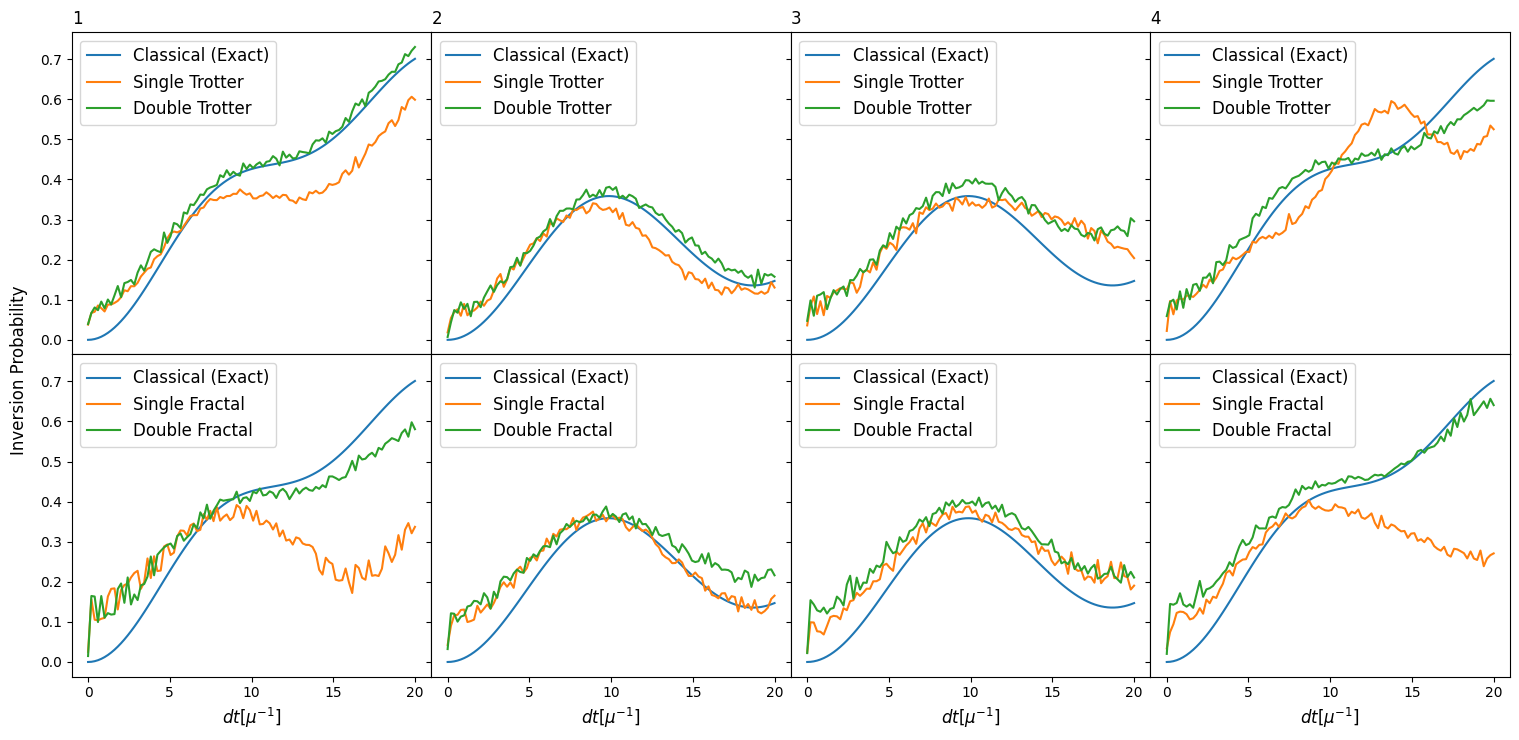

In [102]:
fig, axs = plt.subplots(2,4,figsize=(15, 7.5), sharex=True, sharey=True)

for i in range(N):
    axs[0,i].plot(times, exact_probabilities[i], label=f'Classical (Exact)')
    axs[0,i].plot(times, single_trotter_probabilities[i], label=f'Single Trotter')
    axs[0,i].plot(times, double_trotter_probabilities[i], label=f'Double Trotter')
    axs[0,i].set_title(f"{i+1}", loc='left')
    axs[0,i].legend(loc='upper left', fontsize='large')
    axs[1,i].plot(times, exact_probabilities[i], label=f'Classical (Exact)')
    axs[1,i].plot(times, single_fractal_probabilities[i], label=f'Single Fractal')
    axs[1,i].plot(times, double_fractal_probabilities[i], label=f'Double Fractal')
    axs[1,i].set_xlabel('$dt [\mu^{-1}]$', fontsize='large')
    axs[1,i].legend(loc='upper left',  fontsize='large')
plt.tight_layout()
plt.subplots_adjust(wspace=0)
plt.subplots_adjust(hspace=0)
fig.text(-0.01, 0.5, 'Inversion Probability', va='center', rotation='vertical', fontsize='large')
plt.show()

In [103]:
print(f"Single Trotter Depth: {single_trotter_depth}")
print(f"Double Trotter Depth: {double_trotter_depth}")
print(f"Single Fractal Depth: {single_fractal_depth}")
print(f"Double Fractal Depth: {double_fractal_depth}")

Single Trotter Depth: 118.57
Double Trotter Depth: 106.81
Single Fractal Depth: 212.19
Double Fractal Depth: 190.22


## Short Coherence Time

In [91]:
T1s = np.ones(4) * 60 # nanoseconds
T2s = 2 * T1s
single_gate_time = 1 
double_gate_time = 1
single_gates = ['rx','ry','rz','id']
noise = NoiseModel()
for i in range(4):
    for s in single_gates:
        error = thermal_relaxation_error(T1s[i], T2s[i], single_gate_time)
        noise.add_quantum_error(error, s, [i])
    
for i in range(4):
    for j in range(4):
        if i != j:
            error = thermal_relaxation_error(T1s[i], T2s[i], double_gate_time).expand(thermal_relaxation_error(T1s[j], T2s[j], double_gate_time))
            noise.add_quantum_error(error, 'cz', [i,j])

backend = AerSimulator(noise_model=noise) #AerSimulator()

In [92]:
single_trotter_probabilities, double_trotter_probabilities, single_fractal_probabilities, double_fractal_probabilities, single_trotter_depth, double_trotter_depth, single_fractal_depth, double_fractal_depth = quantum_results(times, backend)

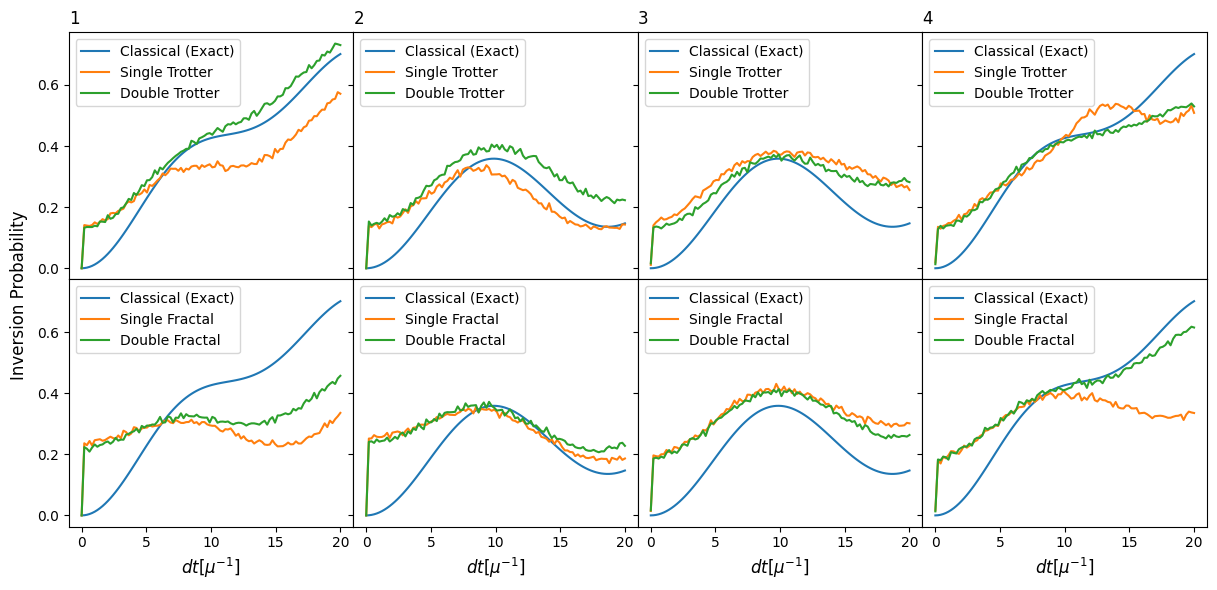

In [93]:
fig, axs = plt.subplots(2,4,figsize=(12, 6), sharex=True, sharey=True)

for i in range(N):
    axs[0,i].plot(times, exact_probabilities[i], label=f'Classical (Exact)')
    axs[0,i].plot(times, single_trotter_probabilities[i], label=f'Single Trotter')
    axs[0,i].plot(times, double_trotter_probabilities[i], label=f'Double Trotter')
    axs[0,i].set_title(f"{i+1}", loc='left')
    axs[0,i].legend(loc='upper left')
    axs[1,i].plot(times, exact_probabilities[i], label=f'Classical (Exact)')
    axs[1,i].plot(times, single_fractal_probabilities[i], label=f'Single Fractal')
    axs[1,i].plot(times, double_fractal_probabilities[i], label=f'Double Fractal')
    axs[1,i].set_xlabel('$dt [\mu^{-1}]$', fontsize='large')
    axs[1,i].legend(loc='upper left')
plt.tight_layout()
plt.subplots_adjust(wspace=0)
plt.subplots_adjust(hspace=0)
fig.text(-0.01, 0.5, 'Inversion Probability', va='center', rotation='vertical', fontsize='large')
plt.show()

In [94]:
print(f"Single Trotter Depth: {single_trotter_depth}")
print(f"Double Trotter Depth: {double_trotter_depth}")
print(f"Single Fractal Depth: {single_fractal_depth}")
print(f"Double Fractal Depth: {single_fractal_depth}")

Single Trotter Depth: 64
Double Trotter Depth: 60
Single Fractal Depth: 112
Double Fractal Depth: 112


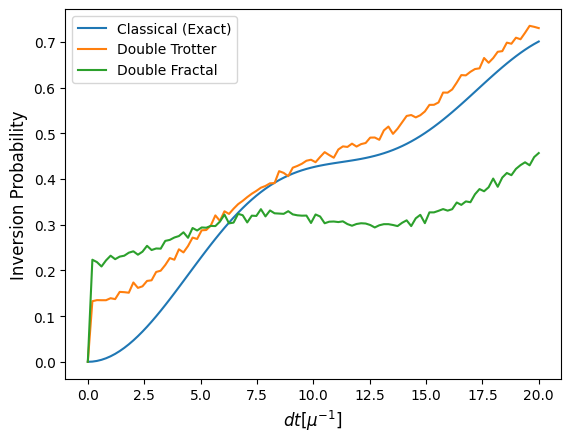

In [95]:
plt.plot(times, exact_probabilities[0], label=f'Classical (Exact)')
plt.plot(times, double_trotter_probabilities[0], label=f'Double Trotter')
plt.plot(times, double_fractal_probabilities[0], label=f'Double Fractal')
plt.xlabel('$dt [\mu^{-1}]$', fontsize='large')
plt.ylabel('Inversion Probability', fontsize='large')
plt.legend(loc='upper left')

plt.show()